## Comparison between theory and simulations for denoising autoencoder

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from numpy.random import normal
from tqdm import tqdm

### Theory

In [78]:
#auxiliary functions for the ODEs
def lt_lt(Delta,sigmas,Q,M,k,S,b):
    return np.outer(M[k,:],M[k,:])*(1-Delta)+((1-Delta)*sigmas[k]**2+Delta)*Q
def lt_lx(Delta,sigmas,Q,M,k,S,b):
    return np.outer(M[k,:],M[k,:])*np.sqrt(1-Delta)+(np.sqrt(1-Delta)*sigmas[k]**2)*Q
def lx_lx(Delta,sigmas,Q,M,k,S,b):
    return np.outer(M[k,:],M[k,:])+(sigmas[k]**2)*Q
def nut_nut(Delta,sigmas,Q,M,k,S,b):
    return np.outer(S[k,:],S[k,:])*(1-Delta)+((1-Delta)*sigmas[k]**2+Delta)*S
def lt_nut(Delta,sigmas,Q,M,k,S,b):
    return np.outer(M[k,:],S[k,:])*(1-Delta)+((1-Delta)*sigmas[k]**2+Delta)*M.T
def lt_nux(Delta,sigmas,Q,M,k,S,b):
    return np.outer(M[k,:],S[k,:])*np.sqrt(1-Delta)+(np.sqrt(1-Delta)*sigmas[k]**2)*M.T
def lx_nut(Delta,sigmas,Q,M,k,S,b):
    return np.outer(M[k,:],S[k,:])*np.sqrt(1-Delta)+(np.sqrt(1-Delta)*sigmas[k]**2)*M.T

def lt_L(Delta,sigmas,Q,M,k,S,b):
    r,_=Q.shape
    return lt_lx(Delta,sigmas,Q,M,k,S,b)-(b*np.eye(r)+Q)@lt_lt(Delta,sigmas,Q,M,k,S,b)
def L_L(Delta,sigmas,Q,M,k,S,b):
    r,_=Q.shape
    A=(b*np.eye(r)+Q)@lt_lx(Delta,sigmas,Q,M,k,S,b)
    return lx_lx(Delta,sigmas,Q,M,k,S,b)-A-A.T+(b*np.eye(r)+Q)@lt_lt(Delta,sigmas,Q,M,k,S,b)@(b*np.eye(r)+Q)
def x_x(Delta,sigmas,Q,M,k,S,b):
    return sigmas[k]**2
def xt_xt(Delta,sigmas,Q,M,k,S,b):
    return (1-Delta)*sigmas[k]**2+Delta
def x_xt(Delta,sigmas,Q,M,k,S,b):
    return  np.sqrt(1-Delta)*sigmas[k]**2

In [79]:
#theoretical ODEs
def update_overlaps(M,Q,eta,Delta,S,b,sigmas,cs):
    K,r=M.shape
    dM=np.zeros((K,r))
    dQ=np.zeros((r,r))

    
    for k in range(K):
        dMtmp=eta*(lt_nux(Delta,sigmas,Q,M,k,S,b).T-2*b*lt_nut(Delta,sigmas,Q,M,k,S,b).T-M@lt_lt(Delta,sigmas,Q,M,k,S,b)\
                   +lx_nut(Delta,sigmas,Q,M,k,S,b).T-lt_nut(Delta,sigmas,Q,M,k,S,b).T@Q)

        dQtmp=(lt_L(Delta,sigmas,Q,M,k,S,b)+lt_L(Delta,sigmas,Q,M,k,S,b).T)*(2*eta+eta**2*(x_xt(Delta,sigmas,Q,M,k,S,b)-b*xt_xt(Delta,sigmas,Q,M,k,S,b)))\
                +eta**2*L_L(Delta,sigmas,Q,M,k,S,b)*xt_xt(Delta,sigmas,Q,M,k,S,b)\
                +eta**2*lt_lt(Delta,sigmas,Q,M,k,S,b)*(x_x(Delta,sigmas,Q,M,k,S,b)-2*b*x_xt(Delta,sigmas,Q,M,k,S,b)+b**2*xt_xt(Delta,sigmas,Q,M,k,S,b))

        
        dM+=cs[k]*dMtmp
        dQ+=cs[k]*dQtmp

    dQ=0.5*(dQ+dQ.T)    
    return dQ,dM

In [80]:
#theoretical MSE
def compute_mse_theory(Delta,sigmas,Q,M,S,b,cs,N):
    K=len(cs)
    mse=0
    for k in range(K):
        mse+=cs[k]*(np.trace(Q@lt_lt(Delta,sigmas,Q,M,k,S,b))\
            -2*np.trace(lt_lx(Delta,sigmas,Q,M,k,S,b))+2*b*np.trace(lt_lt(Delta,sigmas,Q,M,k,S,b)))
    return mse

In [82]:
#integrate theoretical ODEs
def run_forward_dynamics(M0,Q0,S,bs,etas,Deltas,sigmas,cs,num_steps,N,dt=0.01):
    K,r=M0.shape
    M=np.zeros((num_steps+1,K,r))
    Q=np.zeros((num_steps+1,r,r))
    errs=np.zeros(num_steps+1)

    M[0]=M0.copy()
    Q[0]=Q0.copy()
    errs[0]=compute_mse_theory(Deltas[0],sigmas,Q[0],M[0],S,bs[0],cs,N)

    for t in tqdm(range(num_steps)):
        dQ,dM=update_overlaps(M[t],Q[t],etas[t],Deltas[t],S,bs[t],sigmas,cs)
        dQ=0.5*(dQ+dQ.T)
        M[t+1]=M[t]+dt*dM
        Q[t+1]=Q[t]+dt*dQ
        errs[t+1]=compute_mse_theory(Deltas[t+1],sigmas,Q[t+1],M[t+1],S,bs[t+1],cs,N)    
        
    return Q,M,errs

## Numerical simulations

In [ ]:
#MSE from simulations
def compute_mse(w,b,Xtest,Delta):
    
    nsamp,N=Xtest.shape
    
    Xt=np.sqrt(1-Delta)*Xtest+np.sqrt(Delta)*normal(0,1.,size=(nsamp,N))
    lbt=Xt@w.T/np.sqrt(N)
    Xpred=b*Xt+lbt@w/np.sqrt(N)
    
    return np.mean(np.sum((Xpred-Xtest)**2-(b*Xt-Xtest)**2,axis=1))

In [83]:
def generate_data(N,num_samples,sigmas,mus,cs):
    K,N=mus.shape
    coefficients = np.random.choice(K, size=num_samples, p=cs)
    X=np.array([mus[cf]+sigmas[cf]*normal(0,1.,size=N) for cf in coefficients])
    return X.reshape((num_samples,N))

In [85]:
def compute_gradient(w, b, x, xi, Delta, B):
    r, N = w.shape
    Q = w @ w.T / N  
    grad = np.zeros((r, N))
    for i in range(B):
        xi_i = xi[i]
        xt = np.sqrt(1 - Delta) * x + np.sqrt(Delta) * xi_i  
        
        lbdt = w @ xt  
        error = x - b * xt - (w.T @ lbdt) / N  
        Lbd = w @ x - b * lbdt - Q @ lbdt    

        grad += np.outer(lbdt, error) + np.outer(Lbd, xt)

    return -grad / (N * B)

In [86]:
def run_simulations(w0,bs,etas,mus,sigmas,cs,Deltas,num_steps,Deltaf,K,r,samples_test=100,B=1,downsampling=100):
    
    r,N=w0.shape
    
    W=np.zeros((r,N))
    Msim=np.zeros((num_steps//downsampling,K,r))
    Qsim=np.zeros((num_steps//downsampling,r,r))
    errors=np.zeros(num_steps//downsampling)

    W=w0
    X=generate_data(N,num_steps,sigmas,mus,cs)

    Xtest=generate_data(N,samples_test,sigmas,mus,cs)

    count=0
    for t in tqdm(range(num_steps)):
        xi=normal(0,1.,size=(B,N))
        W=W-etas[t]*compute_gradient(W,bs[t],X[t],xi,Deltas[t],B)
        if t%downsampling==0:
            Qsim[count]=W@W.T/N
            Msim[count]=mus@W.T/np.sqrt(N)
            errors[count]=compute_mse(W,bs[t+1],Xtest,Deltaf)
            count=count+1

    return Qsim,Msim,errors

In [87]:
np.random.seed(195)
K=2 #Number of Gaussian clusters (denoted C1 in the paper)
r=2 #Number of network hidden nodes (denoted K in the paper)
N=10000 #Input dimension
alphaF=5 #Total training time
eta=2 #learning rate
T=alphaF*eta
mus=normal(0,1.,size=(K,N))/np.sqrt(N)
sigma=0.1 #Variance of the Gaussian clusters
Deltaf=0.8 #Test noise level
Delta=Deltaf
B0=5 #Batch size
#Initializations
mutmp=np.concatenate((mus,mus),axis=0)
w0=0.2*mutmp[:r]+normal(0,1/np.sqrt(N),size=(r,N))
w0=np.array([w0[p]*np.sqrt(N)/np.linalg.norm(w0[p]) for p in range(r)])/2
M0=mus@w0.T/np.sqrt(N)
Q0=w0@w0.T/N
S=mus@mus.T

In [88]:
### Skip connection = optimal
b0=np.sqrt(1-Deltaf)*sigma**2/(((1-Deltaf)*sigma**2+Deltaf))

In [89]:
np.random.seed(1996)
num_steps=alphaF*N
bs=np.ones(num_steps+1)*b0
Deltas=Deltaf*np.ones(num_steps+1)
cs=np.ones(K)/K
sigmas=np.ones(K)*sigma
etas=np.ones(num_steps+1)*eta
samples_test=10000

In [90]:
Qsim,Msim,errors=run_simulations(w0,bs,etas,mus,sigmas,cs,Deltas,num_steps,Deltaf,K,r,samples_test=samples_test,B=B0,downsampling=1000)

100%|██████████| 50000/50000 [08:26<00:00, 98.75it/s]  


In [91]:
with open('data_'+str(alphaF)+"_"+str(B0)+'.pkl', 'rb') as f:
    data = pickle.load(f)
[J_const,Qs,Ms]=data

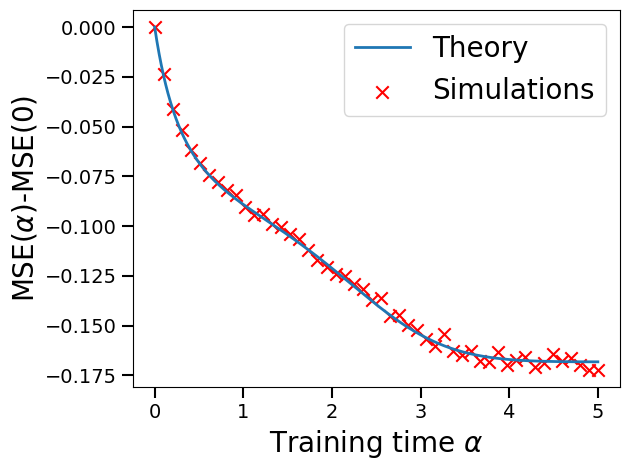

In [92]:
alphas_sim=np.linspace(0,alphaF,len(errors))
alphas_th=np.linspace(0,alphaF,len(J_const))
plt.plot(alphas_th,np.array(J_const)-J_const[0],label="Theory",lw=2)
plt.scatter(alphas_sim,errors-errors[0],label="Simulations",marker='x',s=80,color='r')
plt.ylabel(r"MSE($\alpha$)-MSE(0)",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width
plt.legend(fontsize=20)


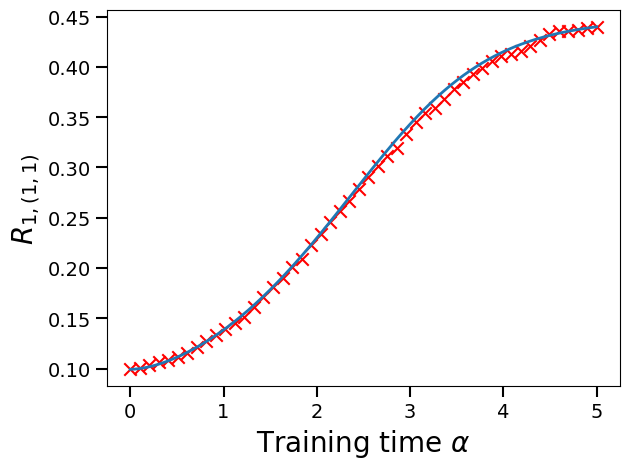

In [93]:
alphas_sim=np.linspace(0,alphaF,len(errors))
alphas_th=np.linspace(0,alphaF,len(J_const))
plt.plot(alphas_th,[Ms[i][0] for i in range(len(Ms))],label="Theory",lw=2)
plt.scatter(alphas_sim,Msim[:,0,0],label="Simulations",marker='x',s=80,color='r')
plt.ylabel(r"$R_{1,(1,1)}$",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width


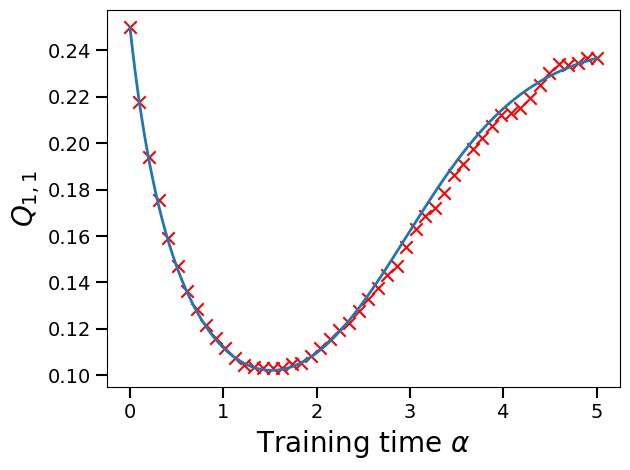

In [94]:
alphas_sim=np.linspace(0,alphaF,len(errors))
alphas_th=np.linspace(0,alphaF,len(J_const))
plt.plot(alphas_th,[Qs[i][0] for i in range(len(Qs))],label="Theory",lw=2)
plt.scatter(alphas_sim,Qsim[:,0,0],label="Simulations",marker='x',s=80,color='r')
plt.ylabel(r"$Q_{1,1}$",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width


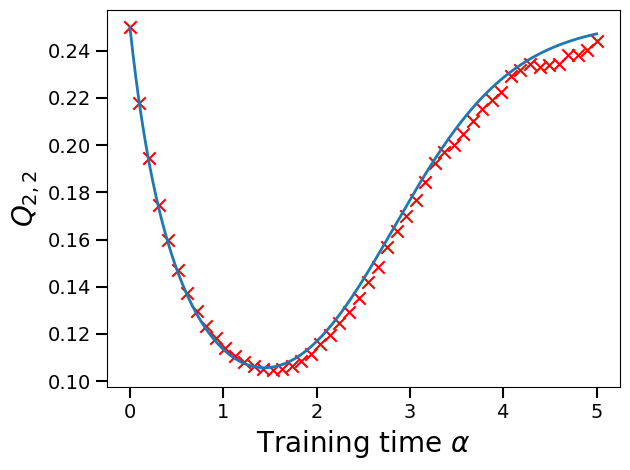

In [95]:
alphas_sim=np.linspace(0,alphaF,len(errors))
alphas_th=np.linspace(0,alphaF,len(J_const))
plt.plot(alphas_th,[Qs[i][3] for i in range(len(Qs))],label="Theory",lw=2)
plt.scatter(alphas_sim,Qsim[:,1,1],label="Simulations",marker='x',s=80,color='r')
plt.ylabel(r"$Q_{2,2}$",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width
